We make the 2D diffusion case in the Forward case.

In [56]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [57]:
# Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("/////////////////\n Tensors type on GPU \n///////////////")
print("/////////////////\n Tensors type on CPU \n///////////////")

/////////////////
 Tensors type on CPU 
///////////////


In [58]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

In [59]:
Lx = 500
Ly = 500
T = 10 #Final Time
D = 0.5*10e-4  #https://www.engineeringtoolbox.com/air-diffusion-coefficient-gas-mixture-temperature-d_2010.html
S = 1000 #peak of the source
S_coord = torch.tensor([Lx/2, Ly/2])

#Geometry and residual
geom = dde.geometry.geometry_2d.Rectangle(np.array([0, 0]), np.array([Lx, Ly]))
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

tensor(0.0380)


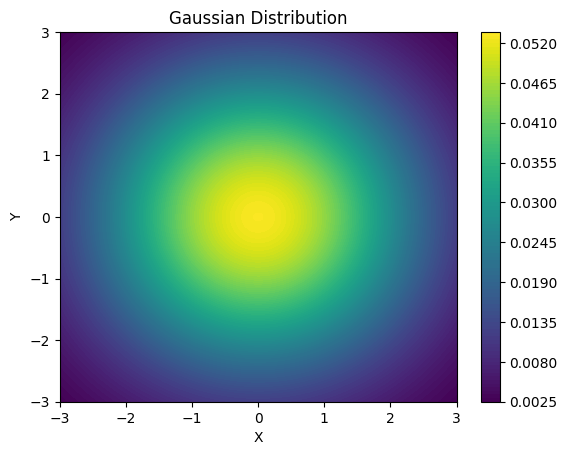

In [60]:
import torch.distributions as distributions

def gaussian_distribution(tensor, mean, std):
    '''2d gaussian with isotropic variance '''
    covariance_matrix = torch.eye(2) * std
    mvn = distributions.MultivariateNormal(mean, covariance_matrix)
    
    return mvn.log_prob(tensor).exp()

# Example usage
tensor = torch.tensor([1.0, 1.0])
mean = torch.tensor([0.0, 0.0])
std = 3.0
result = result = gaussian_distribution(tensor, mean, std)
print(result)


#plot
x = np.linspace(-3, 3, 100) 
y = np.linspace(-3, 3, 100) 
X, Y = np.meshgrid(x, y)
tensor = torch.tensor(np.dstack((X, Y)).reshape(-1, 2))
Z = gaussian_distribution(tensor, mean, std)
Z = Z.reshape(100, 100).numpy()
plt.contourf(X, Y, Z, levels=100, cmap='viridis') 
plt.colorbar() 
plt.xlabel('X') 
plt.ylabel('Y') 
plt.title('Gaussian Distribution') 
plt.show()

In [61]:
#Residual
def pde(p, C):

    """residual of the PDE. shape(p) = (nb_of_point, 3), p[i, 0] = xi; p[i, 1] = yi; p[i, 2] = ti.
    C(p) is the concentration at the point p = (x, y, t)
    All needs to be a pytorch tensor, otherwise it makes some strange error"""

    
    # dC_x = dde.grad.jacobian(C, p, j=0)
    # dC_y = dde.grad.jacobian(C, p, j=1)
    dC_t = dde.grad.jacobian(C, p, j=2)

    dC_xx = dde.grad.hessian(C, p, i=0, j=0)
    dC_yy = dde.grad.hessian(C, p, i=1, j=1)

    return (
        - dC_t
        # - u[0] * dC_x
        # - u[1] * dC_y
        + D * (dC_xx + dC_yy)
        + gaussian_distribution(tensor=p[:, 0:2], mean=S_coord, std=50) * S
    )

In [62]:
#Conditions (Boudary & Initial)
# def IC_func(x):
#     return np.sin(np.pi * x[:, 0:1])

def BC_func(x):
    return 0


# ic = dde.icbc.IC(geomtime, IC_func, lambda _, on_initial: on_initial)
bc = dde.icbc.DirichletBC(geomtime, BC_func, lambda _, on_boundary: on_boundary)


In [71]:
#Data and model
space_discretization= 10 #100 points/edges of the rectangle; 5 points/second
time_discretization = 10


data = dde.data.TimePDE(
    geomtime,
    pde,
    bc,
    # num_domain=space_discretization**2 * time_discretization,
    num_domain = 100,
    # num_boundary=4*space_discretization*time_discretization,
    num_boundary= 50,
    num_test=10000,
)


layer_size = [3] + [32] * 5 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

In [73]:
#Computations and graph
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=7000)


Compiling model...
'compile' took 0.000308 s

Training model...

809       [1.15e-03, 5.85e-06]    [6.46e-03, 5.85e-06]    []  
1000      [1.15e-03, 8.25e-08]    [6.45e-03, 8.25e-08]    []  
2000      [1.15e-03, 5.04e-08]    [6.45e-03, 5.04e-08]    []  
3000      [1.15e-03, 7.30e-08]    [6.45e-03, 7.30e-08]    []  
4000      [1.15e-03, 7.51e-08]    [6.45e-03, 7.51e-08]    []  
5000      [1.15e-03, 9.12e-07]    [6.45e-03, 9.12e-07]    []  
6000      [1.15e-03, 9.14e-08]    [6.45e-03, 9.14e-08]    []  
7000      [1.15e-03, 1.25e-07]    [6.45e-03, 1.25e-07]    []  
7809      [1.15e-03, 1.38e-07]    [6.45e-03, 1.38e-07]    []  

Best model at step 7809:
  train loss: 1.15e-03
  test loss: 6.45e-03
  test metric: []

'train' took 40.958214 s



Saving loss history to c:\Users\Bilal_BM_user\Documents\_Documents\ecole\ENPC\ENPC_2\Projet\Repo_projet\projet-imi\loss.dat ...
Saving training data to c:\Users\Bilal_BM_user\Documents\_Documents\ecole\ENPC\ENPC_2\Projet\Repo_projet\projet-imi\train.dat ...
Saving test data to c:\Users\Bilal_BM_user\Documents\_Documents\ecole\ENPC\ENPC_2\Projet\Repo_projet\projet-imi\test.dat ...


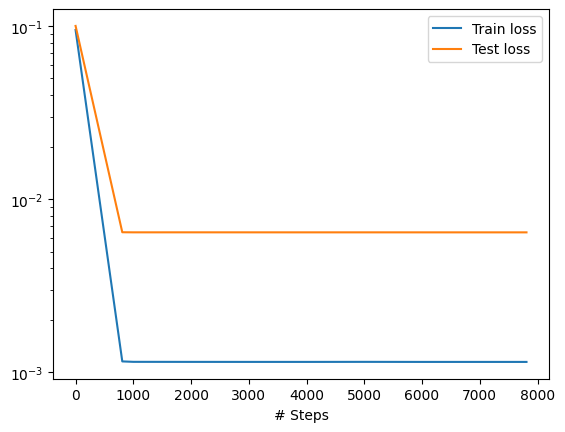

In [74]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

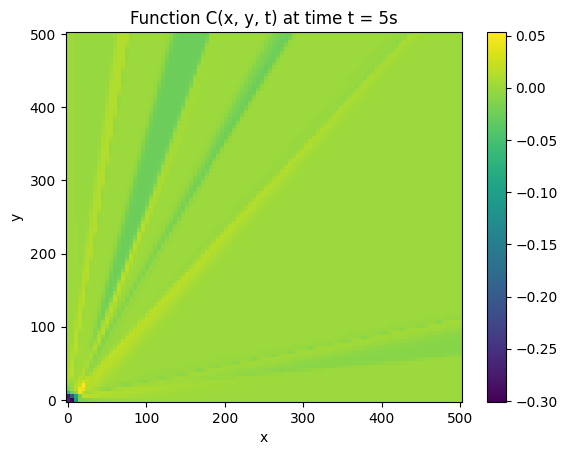

In [75]:
# Define the time t_1 at which you want to display the function
t_1 = 5

# Define the spatial domain where you want to evaluate the function in 2D
x = np.linspace(0, Lx, 100)
y = np.linspace(0, Ly, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the function C(x, y, t) at the specified time t_1 and spatial domain (x, y)
C_x_y_t1 = model.predict(np.column_stack((X.ravel(), Y.ravel(), t_1*np.ones_like(X.ravel())))).reshape(X.shape)# Plot the function C(x, y, t) at time t_1 in 2D
plt.figure()
plt.pcolormesh(X, Y, C_x_y_t1, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function C(x, y, t) at time t = {}s'.format(t_1))
plt.show()
